### The first step is to prepare our work environment by importing the corresponding libraries for the development of the project.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import datetime  
import nltk
from nltk.corpus import stopwords
import pysentiment2
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import pearsonr
import seaborn as sns

wordnet_lem = WordNetLemmatizer()
analyser = SentimentIntensityAnalyzer()

stopwords = nltk.corpus.stopwords.words("english")
regexp = RegexpTokenizer('\w+')

### we create a function to get the sentiment score of a text

In [2]:
def calc_sentiment_score(text):
    return analyser.polarity_scores(text)["compound"]


### We create the stock market dataset using the yfinance library and performing a repetitive cycle to have a single dataset containing all the corresponding companies.

In [3]:
import yfinance as yf
 
start_date = '2015-01-01'
end_date = '2020-01-01'
 
ticker = ['GOOGL','AAPL','GOOG','MSFT','AMZN','TSLA']
StockDf = pd.DataFrame()

for tick in ticker:
    temp = pd.DataFrame(yf.download(tick, start_date, end_date))
    temp['ticker_symbol'] = tick
    
    StockDf = pd.concat([StockDf, temp])

StockDf.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
StockDf.Date = StockDf.Date.astype(str)

In [5]:
StockDf.dtypes

Date              object
Open             float64
High             float64
Low              float64
Close            float64
Adj Close        float64
Volume             int64
ticker_symbol     object
dtype: object

### the main data sets are loaded

In [6]:
Company = pd.read_csv('Company.csv', sep = ",")
Company_Tweet = pd.read_csv('Company_Tweet.csv', sep = ",")
Tweets = pd.read_csv('Tweet.csv', sep = ",")

In [7]:
Company.head()

,ticker_symbol,company_name
0,AAPL,apple
1,GOOG,Google Inc
2,GOOGL,Google Inc
3,AMZN,Amazon.com
4,TSLA,Tesla Inc


In [8]:
Company_Tweet

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL
...,...,...
4336440,1212158772015034369,TSLA
4336441,1212159099632267268,TSLA
4336442,1212159184931717120,TSLA
4336443,1212159838882533376,TSLA


In [9]:
Tweets.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


### The datasets are merged to have a single master table containing all the fields that will be used later.

In [10]:
Company_Tweet = pd.merge(Company_Tweet, Company, on = 'ticker_symbol', how = 'left')

In [11]:
Tweets_MT = pd.merge(Company_Tweet, Tweets, on = 'tweet_id') 

In [12]:
Tweets_MT.head()

,tweet_id,ticker_symbol,company_name,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,apple,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,Amazon.com,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,apple,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,Google Inc,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,Amazon.com,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


In [13]:
Tweets_MT.post_date = Tweets_MT.post_date.apply(lambda x: datetime.datetime.fromtimestamp(x)).astype(str).str[:10]
Tweets_MT

,tweet_id,ticker_symbol,company_name,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,apple,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,Amazon.com,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,apple,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,Google Inc,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,Amazon.com,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
...,...,...,...,...,...,...,...,...,...
4336440,1212158772015034369,TSLA,Tesla Inc,StockJoke,2019-12-31,"I'm getting wasted on NYE, and thanks to @NHTS...",0,0,0
4336441,1212159099632267268,TSLA,Tesla Inc,sweetog76,2019-12-31,$TSLA Very Interesting dude:,0,0,0
4336442,1212159184931717120,TSLA,Tesla Inc,MelaynaLokosky,2019-12-31,If only 2020 brought more self-awareness to Te...,0,1,0
4336443,1212159838882533376,TSLA,Tesla Inc,ShortingIsFun,2019-12-31,In 2020 I may start Tweeting out positive news...,0,0,1


In [15]:
MasterTable = pd.merge(Tweets_MT, StockDf, how = 'inner', left_on = ['post_date', 'ticker_symbol'], right_on = ['Date', 'ticker_symbol'])

### a tokenizer is applied to the text of each tweet

In [16]:
MasterTable['text_token']=MasterTable['body'].apply(regexp.tokenize)
MasterTable.head(3)

,tweet_id,ticker_symbol,company_name,writer,post_date,body,comment_num,retweet_num,like_num,Date,Open,High,Low,Close,Adj Close,Volume,text_token
0,551165812644401152,AAPL,apple,MacHashNews,2015-01-02,"Music streaming expands in 2014, digital sales...",0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[Music, streaming, expands, in, 2014, digital,..."
1,551165070999158785,AAPL,apple,gameofstocks,2015-01-02,$AAPL day traded Apple for the first time ever...,0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[AAPL, day, traded, Apple, for, the, first, ti..."
2,551164964715905025,AAPL,apple,Oakgrovecapital,2015-01-02,When was Fred Wilson last right about $AAPL ? ...,0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[When, was, Fred, Wilson, last, right, about, ..."


### stopwords are removed from tokenized text

In [17]:
MasterTable['text_token'] = MasterTable['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
MasterTable.head(3)

,tweet_id,ticker_symbol,company_name,writer,post_date,body,comment_num,retweet_num,like_num,Date,Open,High,Low,Close,Adj Close,Volume,text_token
0,551165812644401152,AAPL,apple,MacHashNews,2015-01-02,"Music streaming expands in 2014, digital sales...",0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[Music, streaming, expands, 2014, digital, sal..."
1,551165070999158785,AAPL,apple,gameofstocks,2015-01-02,$AAPL day traded Apple for the first time ever...,0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[AAPL, day, traded, Apple, first, time, ever, ..."
2,551164964715905025,AAPL,apple,Oakgrovecapital,2015-01-02,When was Fred Wilson last right about $AAPL ? ...,0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[When, Fred, Wilson, last, right, AAPL, broken..."


###  The tokenized text is reattached for further processing.

In [18]:
MasterTable['text_string'] = MasterTable['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
MasterTable[['body', 'text_token', 'text_string']].head()

,body,text_token,text_string
0,"Music streaming expands in 2014, digital sales...","[Music, streaming, expands, 2014, digital, sal...",Music streaming expands 2014 digital sales dro...
1,$AAPL day traded Apple for the first time ever...,"[AAPL, day, traded, Apple, first, time, ever, ...",AAPL day traded Apple first time ever today ht...
2,When was Fred Wilson last right about $AAPL ? ...,"[When, Fred, Wilson, last, right, AAPL, broken...",When Fred Wilson last right AAPL brokenclock h...
3,Free 5€ in account balance for first 100.000 m...,"[Free, 5, account, balance, first, 100, 000, m...",Free account balance first 100 000 members htt...
4,Apple Sees Unusually Large Options Volume $AAP...,"[Apple, Sees, Unusually, Large, Options, Volum...",Apple Sees Unusually Large Options Volume AAPL...


### The frequency of the words in the dataset is obtained and the less frequent words are eliminated

In [19]:
all_words = ' '.join([word for word in MasterTable['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)
fdist = FreqDist(tokenized_words)


MasterTable['text_string_fdist'] = MasterTable['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
MasterTable.head()

,tweet_id,ticker_symbol,company_name,writer,post_date,body,comment_num,retweet_num,like_num,Date,Open,High,Low,Close,Adj Close,Volume,text_token,text_string,text_string_fdist
0,551165812644401152,AAPL,apple,MacHashNews,2015-01-02,"Music streaming expands in 2014, digital sales...",0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[Music, streaming, expands, 2014, digital, sal...",Music streaming expands 2014 digital sales dro...,Music streaming expands 2014 digital sales dro...
1,551165070999158785,AAPL,apple,gameofstocks,2015-01-02,$AAPL day traded Apple for the first time ever...,0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[AAPL, day, traded, Apple, first, time, ever, ...",AAPL day traded Apple first time ever today ht...,AAPL day traded Apple first time ever today ht...
2,551164964715905025,AAPL,apple,Oakgrovecapital,2015-01-02,When was Fred Wilson last right about $AAPL ? ...,0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[When, Fred, Wilson, last, right, AAPL, broken...",When Fred Wilson last right AAPL brokenclock h...,When Fred Wilson last right AAPL brokenclock h...
3,551163212813860864,AAPL,apple,Sara20992,2015-01-02,Free 5€ in account balance for first 100.000 m...,0,0,1,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[Free, 5, account, balance, first, 100, 000, m...",Free account balance first 100 000 members htt...,Free account balance first 100 000 members htt...
4,551162010856349696,AAPL,apple,AmericanBanking,2015-01-02,Apple Sees Unusually Large Options Volume $AAP...,0,0,0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.603207,212818400,"[Apple, Sees, Unusually, Large, Options, Volum...",Apple Sees Unusually Large Options Volume AAPL...,Apple Sees Unusually Large Options Volume AAPL...


### A lemmatizer is applied to the processed text to bring the words to their root to be processed by the sentiment analysis instance. 

In [20]:
MasterTable['text_string_lem'] = MasterTable['text_string_fdist'].apply(wordnet_lem.lemmatize)
MasterTable['text_string_lem'].head(3)

0    Music streaming expands 2014 digital sales dro...
1    AAPL day traded Apple first time ever today ht...
2    When Fred Wilson last right AAPL brokenclock h...
Name: text_string_lem, dtype: object

### the sentiment score and the sentiment classification is obtained by using the vader dictionary and the SentimentIntensityAnalyzer library. 

In [21]:
MasterTable['sentiment_score'] = MasterTable['text_string_lem'].apply(calc_sentiment_score)
MasterTable.head()

,tweet_id,ticker_symbol,company_name,writer,post_date,body,comment_num,retweet_num,like_num,Date,...,High,Low,Close,Adj Close,Volume,text_token,text_string,text_string_fdist,text_string_lem,sentiment_score
0,551165812644401152,AAPL,apple,MacHashNews,2015-01-02,"Music streaming expands in 2014, digital sales...",0,0,0,2015-01-02,...,27.860001,26.8375,27.3325,24.603207,212818400,"[Music, streaming, expands, 2014, digital, sal...",Music streaming expands 2014 digital sales dro...,Music streaming expands 2014 digital sales dro...,Music streaming expands 2014 digital sales dro...,-0.1779
1,551165070999158785,AAPL,apple,gameofstocks,2015-01-02,$AAPL day traded Apple for the first time ever...,0,0,0,2015-01-02,...,27.860001,26.8375,27.3325,24.603207,212818400,"[AAPL, day, traded, Apple, first, time, ever, ...",AAPL day traded Apple first time ever today ht...,AAPL day traded Apple first time ever today ht...,AAPL day traded Apple first time ever today ht...,0.0000
2,551164964715905025,AAPL,apple,Oakgrovecapital,2015-01-02,When was Fred Wilson last right about $AAPL ? ...,0,0,0,2015-01-02,...,27.860001,26.8375,27.3325,24.603207,212818400,"[When, Fred, Wilson, last, right, AAPL, broken...",When Fred Wilson last right AAPL brokenclock h...,When Fred Wilson last right AAPL brokenclock h...,When Fred Wilson last right AAPL brokenclock h...,-0.7096
3,551163212813860864,AAPL,apple,Sara20992,2015-01-02,Free 5€ in account balance for first 100.000 m...,0,0,1,2015-01-02,...,27.860001,26.8375,27.3325,24.603207,212818400,"[Free, 5, account, balance, first, 100, 000, m...",Free account balance first 100 000 members htt...,Free account balance first 100 000 members htt...,Free account balance first 100 000 members htt...,0.5106
4,551162010856349696,AAPL,apple,AmericanBanking,2015-01-02,Apple Sees Unusually Large Options Volume $AAP...,0,0,0,2015-01-02,...,27.860001,26.8375,27.3325,24.603207,212818400,"[Apple, Sees, Unusually, Large, Options, Volum...",Apple Sees Unusually Large Options Volume AAPL...,Apple Sees Unusually Large Options Volume AAPL...,Apple Sees Unusually Large Options Volume AAPL...,0.0000


In [22]:
MasterTable['sentiment'] = MasterTable['sentiment_score'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
MasterTable.head(4)

,tweet_id,ticker_symbol,company_name,writer,post_date,body,comment_num,retweet_num,like_num,Date,...,Low,Close,Adj Close,Volume,text_token,text_string,text_string_fdist,text_string_lem,sentiment_score,sentiment
0,551165812644401152,AAPL,apple,MacHashNews,2015-01-02,"Music streaming expands in 2014, digital sales...",0,0,0,2015-01-02,...,26.8375,27.3325,24.603207,212818400,"[Music, streaming, expands, 2014, digital, sal...",Music streaming expands 2014 digital sales dro...,Music streaming expands 2014 digital sales dro...,Music streaming expands 2014 digital sales dro...,-0.1779,negative
1,551165070999158785,AAPL,apple,gameofstocks,2015-01-02,$AAPL day traded Apple for the first time ever...,0,0,0,2015-01-02,...,26.8375,27.3325,24.603207,212818400,"[AAPL, day, traded, Apple, first, time, ever, ...",AAPL day traded Apple first time ever today ht...,AAPL day traded Apple first time ever today ht...,AAPL day traded Apple first time ever today ht...,0.0000,neutral
2,551164964715905025,AAPL,apple,Oakgrovecapital,2015-01-02,When was Fred Wilson last right about $AAPL ? ...,0,0,0,2015-01-02,...,26.8375,27.3325,24.603207,212818400,"[When, Fred, Wilson, last, right, AAPL, broken...",When Fred Wilson last right AAPL brokenclock h...,When Fred Wilson last right AAPL brokenclock h...,When Fred Wilson last right AAPL brokenclock h...,-0.7096,negative
3,551163212813860864,AAPL,apple,Sara20992,2015-01-02,Free 5€ in account balance for first 100.000 m...,0,0,1,2015-01-02,...,26.8375,27.3325,24.603207,212818400,"[Free, 5, account, balance, first, 100, 000, m...",Free account balance first 100 000 members htt...,Free account balance first 100 000 members htt...,Free account balance first 100 000 members htt...,0.5106,positive


### The date field has been modified to obtain monthly periods for each tweet.

In [32]:
MasterTable['Period'] = MasterTable['Date'].str.slice(0, 7)
MasterTable

,tweet_id,ticker_symbol,company_name,writer,post_date,body,comment_num,retweet_num,like_num,Date,...,Close,Adj Close,Volume,text_token,text_string,text_string_fdist,text_string_lem,sentiment_score,sentiment,Period
0,551165812644401152,AAPL,apple,MacHashNews,2015-01-02,"Music streaming expands in 2014, digital sales...",0,0,0,2015-01-02,...,27.332500,24.603207,212818400,"[Music, streaming, expands, 2014, digital, sal...",Music streaming expands 2014 digital sales dro...,Music streaming expands 2014 digital sales dro...,Music streaming expands 2014 digital sales dro...,-0.1779,negative,2015-01
1,551165070999158785,AAPL,apple,gameofstocks,2015-01-02,$AAPL day traded Apple for the first time ever...,0,0,0,2015-01-02,...,27.332500,24.603207,212818400,"[AAPL, day, traded, Apple, first, time, ever, ...",AAPL day traded Apple first time ever today ht...,AAPL day traded Apple first time ever today ht...,AAPL day traded Apple first time ever today ht...,0.0000,neutral,2015-01
2,551164964715905025,AAPL,apple,Oakgrovecapital,2015-01-02,When was Fred Wilson last right about $AAPL ? ...,0,0,0,2015-01-02,...,27.332500,24.603207,212818400,"[When, Fred, Wilson, last, right, AAPL, broken...",When Fred Wilson last right AAPL brokenclock h...,When Fred Wilson last right AAPL brokenclock h...,When Fred Wilson last right AAPL brokenclock h...,-0.7096,negative,2015-01
3,551163212813860864,AAPL,apple,Sara20992,2015-01-02,Free 5€ in account balance for first 100.000 m...,0,0,1,2015-01-02,...,27.332500,24.603207,212818400,"[Free, 5, account, balance, first, 100, 000, m...",Free account balance first 100 000 members htt...,Free account balance first 100 000 members htt...,Free account balance first 100 000 members htt...,0.5106,positive,2015-01
4,551162010856349696,AAPL,apple,AmericanBanking,2015-01-02,Apple Sees Unusually Large Options Volume $AAP...,0,0,0,2015-01-02,...,27.332500,24.603207,212818400,"[Apple, Sees, Unusually, Large, Options, Volum...",Apple Sees Unusually Large Options Volume AAPL...,Apple Sees Unusually Large Options Volume AAPL...,Apple Sees Unusually Large Options Volume AAPL...,0.0000,neutral,2015-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705766,906355243251838976,GOOGL,Google Inc,OACtrading,2017-09-08,NOW OFFERING 7 Day FREE Trial to options day ...,0,0,0,2017-09-08,...,47.070499,47.070499,19998000,"[NOW, OFFERING, 7, Day, FREE, Trial, options, ...",NOW OFFERING Day FREE Trial options day tradin...,NOW OFFERING Day FREE Trial options day tradin...,NOW OFFERING Day FREE Trial options day tradin...,0.6166,positive,2017-09
3705767,906359024114962433,GOOGL,Google Inc,ExactOptionPick,2017-09-08,ACTIVE TRADERS Try one of these FREE trading g...,0,0,0,2017-09-08,...,47.070499,47.070499,19998000,"[ACTIVE, TRADERS, Try, one, FREE, trading, gui...",ACTIVE TRADERS Try one FREE trading guides htt...,ACTIVE TRADERS Try one FREE trading guides htt...,ACTIVE TRADERS Try one FREE trading guides htt...,0.8159,positive,2017-09
3705768,906364686781820928,GOOGL,Google Inc,PrudentBiotech,2017-09-08,Biotech Bonanza: A Key Piece Falls In Placehtt...,0,0,0,2017-09-08,...,47.070499,47.070499,19998000,"[Biotech, Bonanza, A, Key, Piece, Falls, In, P...",Biotech Bonanza Key Piece Falls Placehttps buf...,Biotech Bonanza Key Piece Falls Placehttps buf...,Biotech Bonanza Key Piece Falls Placehttps buf...,0.0000,neutral,2017-09
3705769,906375448871018496,GOOGL,Google Inc,raymond10mm,2017-09-08,$SPX $NASDAQ $DJIA $CAC $DAX $FTSE $JPM $TSLA ...,0,1,1,2017-09-08,...,47.070499,47.070499,19998000,"[SPX, NASDAQ, DJIA, CAC, DAX, FTSE, JPM, TSLA,...",SPX NASDAQ DJIA CAC DAX FTSE JPM TSLA ES_F CL_...,SPX NASDAQ DJIA CAC DAX FTSE JPM TSLA ES_F CL_...,SPX NASDAQ DJIA CAC DAX FTSE JPM TSLA ES_F CL_...,0.0000,neutral,2017-09


### the dataset is divided by each existing company

In [68]:
AAPL = MasterTable.loc[MasterTable['ticker_symbol'] == "AAPL"]
GOOG  = MasterTable.loc[(MasterTable['ticker_symbol'] == "GOOG") | (MasterTable['ticker_symbol'] == "GOOGL") ]
AMZN  = MasterTable.loc[MasterTable['ticker_symbol'] == "AMZN"]
TSLA  = MasterTable.loc[MasterTable['ticker_symbol'] == "TSLA"]

AAPL.set_index('Period', inplace=True)
GOOG.set_index('Period', inplace=True)
AMZN.set_index('Period', inplace=True)
TSLA.set_index('Period', inplace=True)

### The coorrelation between the sentiment score and the adj close is obtained, which is chosen as the final value of the company. 

In [34]:
print(AAPL['sentiment_score'].corr(AAPL['Adj Close']))

0.12568466884287105


In [35]:
print(GOOG['sentiment_score'].corr(GOOG['Adj Close']))

0.06911131404752417


In [36]:
print(AMZN['sentiment_score'].corr(AMZN['Adj Close']))

0.04520121416124599


In [37]:
print(TSLA['sentiment_score'].corr(TSLA['Adj Close']))

0.020778170113726978


### The time series of the evolution of the sentiment score for each company is performed. 

<AxesSubplot:xlabel='Period'>

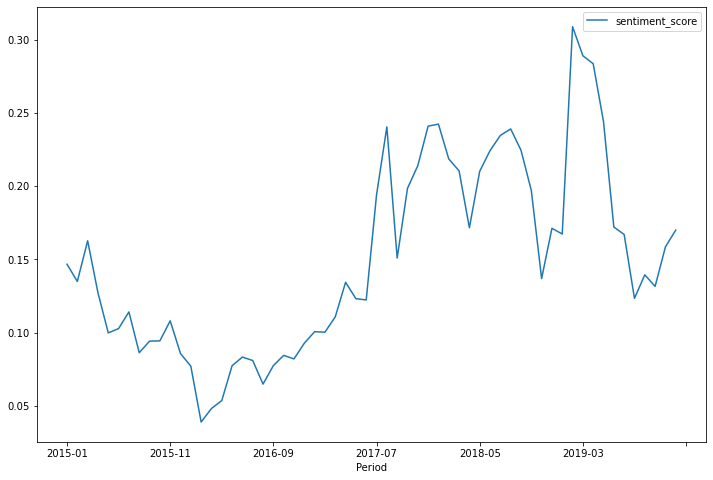

In [69]:
AAPL_S = AAPL[['sentiment_score']]

AAPL_S.groupby(level=0).mean().plot()

<AxesSubplot:xlabel='Period'>

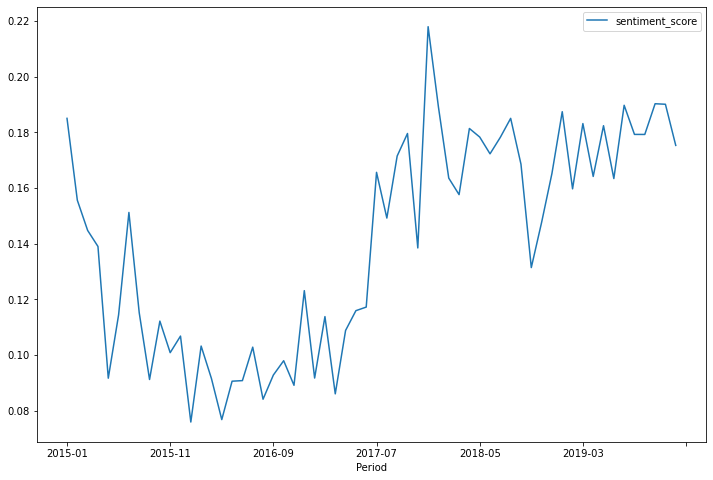

In [61]:
GOOG_S = GOOG[['sentiment_score']]

GOOG_S.groupby(level=0).mean().plot()

<AxesSubplot:xlabel='Period'>

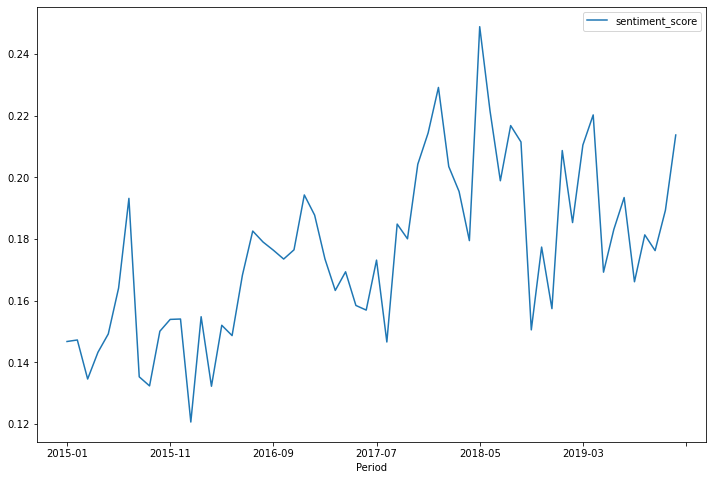

In [62]:
AMZN_S = AMZN[['sentiment_score']]

AMZN_S.groupby(level=0).mean().plot()

<AxesSubplot:xlabel='Period'>

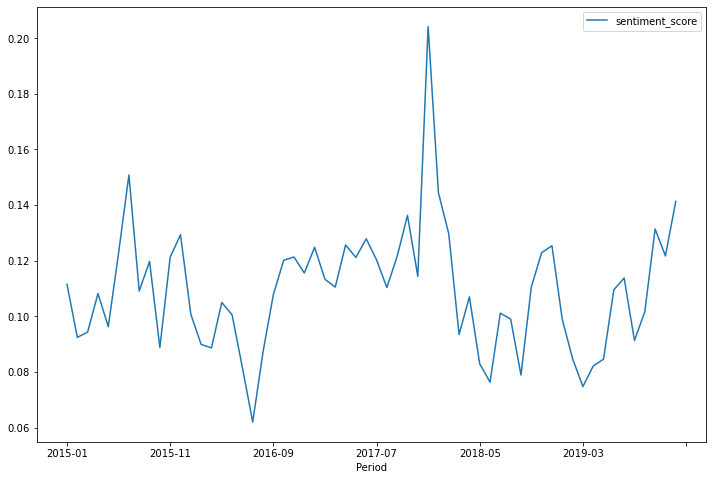

In [63]:
TSLA_S = TSLA[['sentiment_score']]

TSLA_S.groupby(level=0).mean().plot()